First, we import the basic modules and tweak figure display parameters

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

#set precision for displaying float-point values in the notebook
pd.options.display.float_format = '{:,.3f}'.format

#set figure dpi to 100 to get reasonably sized figures displayed in the notebook
plt.rc('figure', dpi=100)

#set savefig dpi to 300 to get high-quality images to insert in the paper
plt.rc('savefig', dpi=300)

#set to 'pdf' or 'eps' for vector figures or to 'png'
plt.rc('savefig', format='png')

#set font sizes for figures throughout
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)

Then, we read the data (assuming it's already pre-processed). Change the path to the files if necessary

In [2]:
import data_reader
dr = data_reader.DataReader()

# if Exp1 and Exp2 data need to be plotted alongside each other, read those data into separate dataframes
exp_1, exp_2 = 'HEM_exp_1', 'HEM_exp_2'
choices_1, dynamics_1 = dr.get_data(path='../../data/%s/processed/' % (exp_1))
choices_2, dynamics_2 = dr.get_data(path='../../data/%s/processed/' % (exp_2))

#if only one of Experiment 1 and 2 is to be analyzed, choose data input:
# exp = 'HEM_exp_1'
# choices, dynamics = dr.get_data(path='../../data/%s/processed/' % (exp))
# subjects = choices.subj_id.unique()

To start with, look at probability of change-of-mind for each individual participant

In [3]:
def print_p_com(choices):
    display(HTML(choices.groupby(level='subj_id').is_com.mean().rename('p_com').to_frame().
                 to_html(formatters={'p_com': '{:,.1%}'.format})))

print_p_com(choices_1)
print_p_com(choices_2)

,p_com
subj_id,
269,4.4%
275,0.4%
391,7.3%
451,1.0%


,p_com
subj_id,
166,3.8%
518,2.5%
624,3.0%


Plot probability and number of changes-of-mind per participant per coherence level

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'subj_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


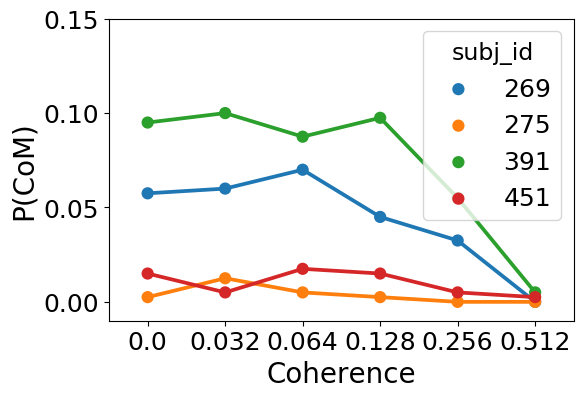

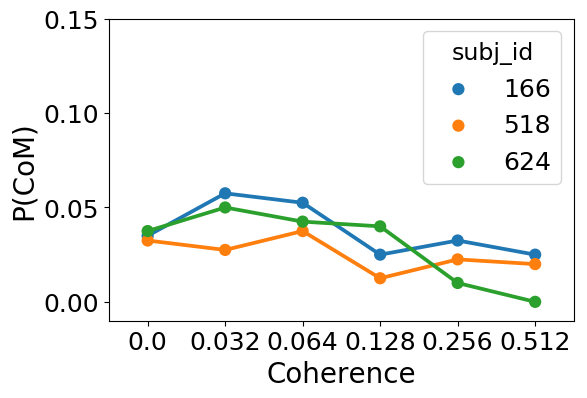

In [4]:
def plot_p_com_vs_coherence(choices, exp):
    plt.figure()
    p_com = choices.groupby(by=['subj_id', 'coherence']).apply(lambda c: len(c[c.is_com])/len(c)).rename('p_com')
    ax = sns.pointplot(data=p_com.reset_index(), x='coherence', y='p_com', hue='subj_id', ci=None)
    ax.set_xlabel('Coherence')
    ax.set_ylabel('P(CoM)')
    ax.set_ylim([-0.01, 0.15]);
    
    plt.savefig('figures/p_com_vs_coherence_%s' % (exp))

plot_p_com_vs_coherence(choices_1, exp_1)
plot_p_com_vs_coherence(choices_2, exp_2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'subj_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


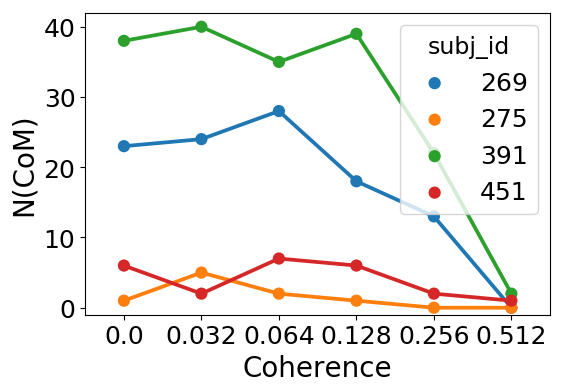

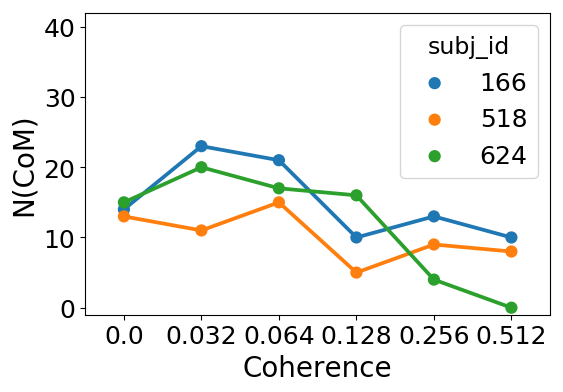

In [5]:
def plot_n_com_vs_coherence(choices, exp):
    plt.figure()
    com_count = choices.groupby(by=['subj_id', 'coherence']).apply(lambda c: len(c[c.is_com])).rename('com_count')
    ax = sns.pointplot(data=com_count.reset_index(), x='coherence', y='com_count', hue='subj_id', ci=None, scale=1)
    ax.set_xlabel('Coherence')
    ax.set_ylabel('N(CoM)')
    ax.set_ylim([-1, 42])
    plt.savefig('figures/n_com_vs_coherence_%s' % (exp))

plot_n_com_vs_coherence(choices_1, exp_1)
plot_n_com_vs_coherence(choices_2, exp_2)

Plot individual psychometric functions separately for CoM and no-Com trials

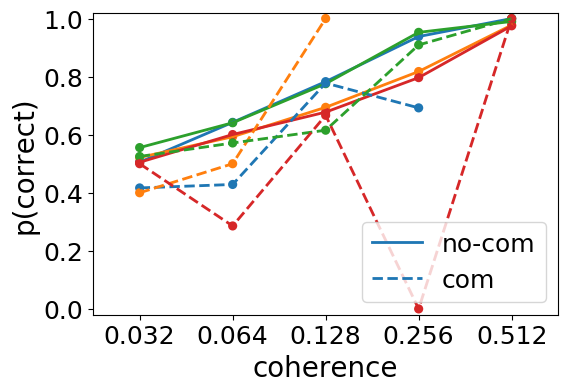

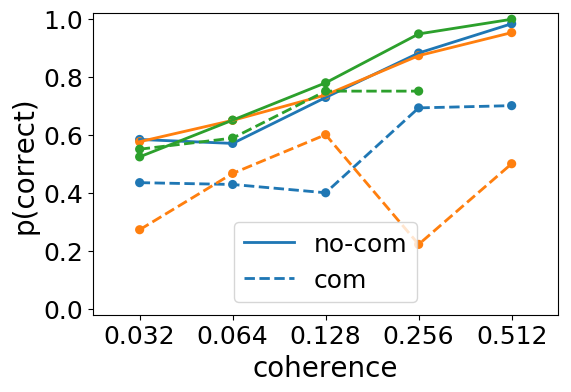

In [6]:
def plot_psychometric_function_individual(c, color):
    psf = [len(c[(c.is_correct) & (c.coherence==coherence) & (c.is_com==is_com)]) / 
                   len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
               if len(c[(c.coherence==coherence) & (c.is_com==is_com)]) else np.NaN 
           for coherence in np.sort(c.coherence.unique()) 
           for is_com in np.sort(c.is_com.unique())]
    
    p_correct = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_com.unique())], 
                                                         names=['coherence', 'is_com']))
    
    ax = sns.pointplot(data=p_correct.reset_index(), x='coherence', y='p_correct', hue='is_com',
                       palette=[color, color], linestyles=['-', '--'], scale=0.75)
    
    ax.set_xlabel('coherence')
    ax.set_ylabel('p(correct)')
    ax.legend(handles=ax.lines[::len(c.coherence.unique())+1], labels=['no-com','com'])
    
    return ax

def plot_psychometric_functions(choices, exp):
    plt.figure()
    choices = choices[~(choices.coherence==0)]
    colors = ['C0', 'C1', 'C2', 'C3']
    for i, subj_id in enumerate(np.sort(choices.index.get_level_values('subj_id').unique().values)):
        ax = plot_psychometric_function_individual(choices.loc[subj_id], color=colors[i])
    ax.set_ylim([-0.02, 1.02])
    plt.savefig('figures/psychometric_function_individual_%s' % (exp))

plot_psychometric_functions(choices_1, exp_1)
plot_psychometric_functions(choices_2, exp_2)

Note that as Participant 275 (green lines) has very few CoMs, their psychometric function is very noisy, especially at higher coherence levels. For this reason, we probably won't be able to fit the model to this individual, and also maybe Participant 451. If we don't do individual fits though, we can just fit to psychometric function calculated for all participant within an experiment. This is what it looks like

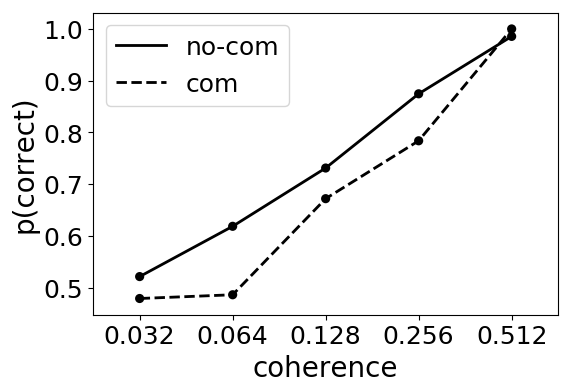

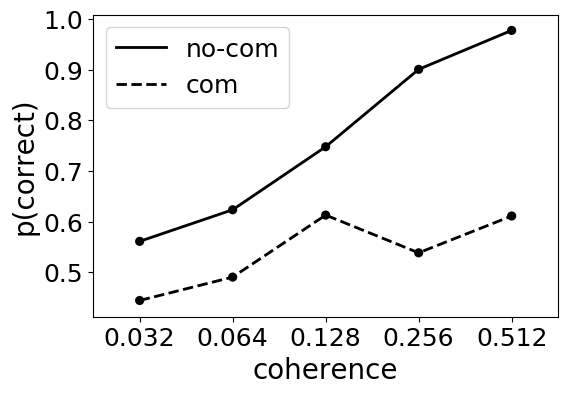

In [7]:
def plot_psychometric_function_aggregate(c, color='k'):
    plt.figure()
    c = c[~(c.coherence==0)]
    psf = [len(c[(c.is_correct) & (c.coherence==coherence) & (c.is_com==is_com)]) / 
                   len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
               if len(c[(c.coherence==coherence) & (c.is_com==is_com)]) else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for is_com in np.sort(c.is_com.unique())]
    
    p_correct = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_com.unique())], 
                                                         names=['coherence', 'is_com']))
    ax = sns.pointplot(data=p_correct.reset_index(), x='coherence', y='p_correct', hue='is_com',
                       palette=[color, color], linestyles=['-', '--'], scale = 0.75)
    
    ax.set_xlabel('coherence')
    ax.set_ylabel('p(correct)')
    ax.legend(handles=ax.lines[::len(c.coherence.unique())+1], labels=['no-com','com'])
    
    return ax

plot_psychometric_function_aggregate(choices_1)
plt.savefig('figures/psychometric_function_%s' % (exp_1))

plot_psychometric_function_aggregate(choices_2)
plt.savefig('figures/psychometric_function_%s' % (exp_2))

Let's look at the same psychometric functions with [binomial proportion confidence intervals](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval). 

Following Resulaj et al (2009), whiskers denote s.e.m. (rather than 95% CI).

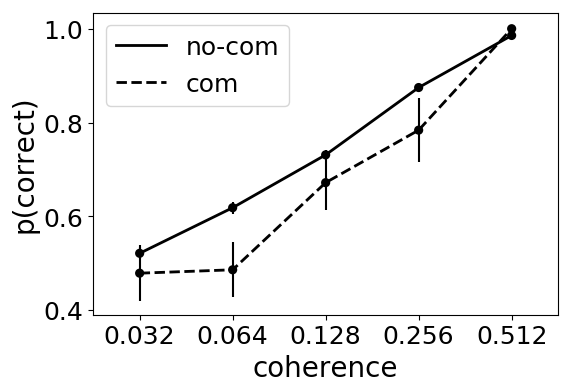

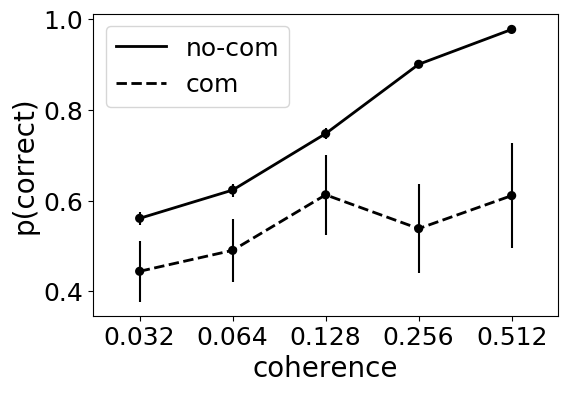

In [8]:
def get_ci(c):
    psf = np.array([len(c[(c.is_correct) & (c.coherence==coherence) & (c.is_com==is_com)]) / 
                   len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
               if len(c[(c.coherence==coherence) & (c.is_com==is_com)]) else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for is_com in np.sort(c.is_com.unique())])
    n = [len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
                      for coherence in np.sort(c.coherence.unique()) 
                      for is_com in np.sort(c.is_com.unique())]

    ci = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_com.unique())], 
                                                         names=['coherence', 'is_com']))
    ci['ci_l'] = ci['p_correct'] - np.sqrt(psf*(1-psf)/n)
    ci['ci_r'] = ci['p_correct'] + np.sqrt(psf*(1-psf)/n)
    
    return ci.reset_index()

def plot_psychometric_function_ci(choices, exp):
    choices = choices[~(choices.coherence==0)]
    ax = plot_psychometric_function_aggregate(choices)
    ci = get_ci(choices)
    ax.vlines(x=[val for pair in zip(range(0,5), range(0,5)) for val in pair], 
              ymin=ci.ci_l, ymax=ci.ci_r, color='k', zorder=10)
    plt.savefig('figures/psychometric_function_ci_%s' % (exp))
    
plot_psychometric_function_ci(choices_1, exp_1)
plot_psychometric_function_ci(choices_2, exp_2)


Let's look at probability of CoM for trials with different initation times

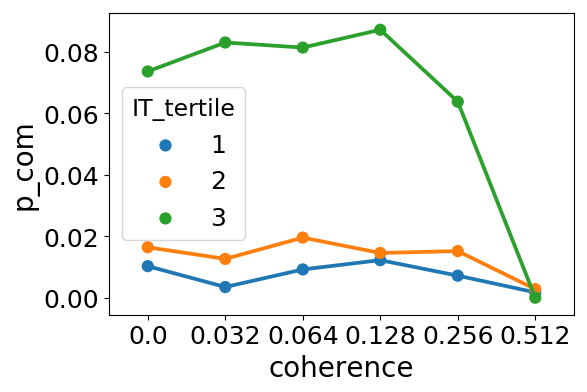

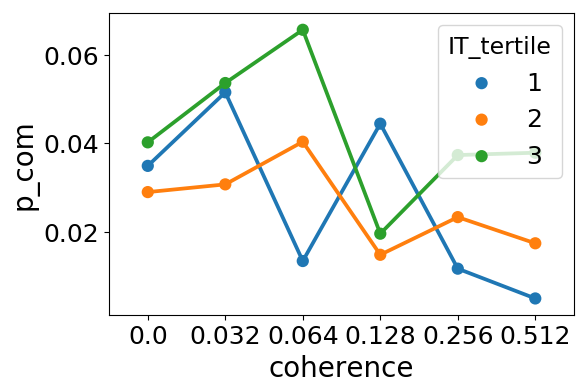

In [10]:
def plot_p_com_vs_IT(choices):
    plt.figure()
    choices['IT_tertile'] = pd.cut(choices.mouse_IT, bins=choices.mouse_IT.quantile([0, .33, .66, 1]), labels=['1', '2', '3'])
    p_com = choices.groupby(by=['coherence', 'IT_tertile']).apply(lambda c: len(c[c.is_com])/len(c)).rename('p_com')
    n_com = choices.groupby(by=['coherence', 'IT_tertile']).apply(lambda c: len(c[c.is_com])).rename('n_com')
    sns.pointplot(data=p_com.reset_index(), x='coherence', y='p_com', hue='IT_tertile')

plot_p_com_vs_IT(choices_1)
plot_p_com_vs_IT(choices_2)